In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import networkx as nx
import scipy.sparse
from nn_homology import nn_graph
import persim

torch.manual_seed(2)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.fc1 = nn.Linear(6912, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.param_info = [{'layer_type': 'Conv2d', 'kernel_size':(3,3), 'stride':1, 'padding': 0, 'name':'Conv1'},
                            {'layer_type': 'Conv2d', 'kernel_size':(3,3), 'stride':1, 'padding':0, 'name':'Conv2'},
                            {'layer_type':'Linear', 'name': 'Linear1'},
                            {'layer_type':'Linear', 'name': 'Linear2'}]
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
from topologylayer.util.construction import clique_complex
from topologylayer.functional.flag import FlagDiagramDistance
from topologylayer import SimplicialComplex
from topologylayer.nn import SumBarcodeLengths, TopKBarcodeLengths

import torch.nn as nn
import numpy as np

class RipsLayer(nn.Module):
    """
    Rips persistence layer
    Parameters:
        n : number of points
        maxdim : maximum homology dimension (default=1)
        alg : algorithm
            'hom' = homology (default)
            'cohom' = cohomology
    """
    def __init__(self, G, maxdim=0, alg='hom'):
        super(RipsLayer, self).__init__()
        self.maxdim = maxdim
        
        X = SimplicialComplex()
        
        adj = scipy.sparse.tril(nx.to_scipy_sparse_matrix(G)).tocoo()
        for i,j,v in zip(adj.row, adj.col, adj.data):
            if j < i:
                X.append([i])
                X.append([j])
                X.append([i,j])
        
        self.complex = X
        self.complex.initialize()
        self.fnobj = FlagDiagramDistance()
        self.alg = alg

    def forward(self, x):
        dgms = self.fnobj.apply(self.complex, x, self.maxdim, self.alg)
        return dgms, True

In [4]:
def flatten_params_torch(param_info, device):
    param_vecs = []
    for param in param_info:
        if param['layer_type'] == 'Conv2d':
            p = param['param']
            param_vecs.append(p.reshape(p.shape[0],-1).flatten())
        if param['layer_type'] == 'Linear':
            p = param['param']
            param_vecs.append(p.flatten())

    # make the first element zero (could be anything given we're filtering below)
    param_vecs = [torch.zeros(1).to(device)] + param_vecs
    param_vec = torch.cat(param_vecs)

    return param_vec


def train(model, param_info, G, device, train_loader, optimizer, epoch, lbda, p, log_interval=10, update_every=10, k=10):
#     losslayer = SumBarcodeLengths(dim=0)
    losslayer = TopKBarcodeLengths(dim=0, k=k)
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        up = nn_graph.append_params(model.param_info, nn_graph.get_weights(model, tensors=True))
        params = flatten_params_torch(up, device)
        
        if batch_idx % update_every == 0:
            paramsnp = flatten_params_torch(up, device).cpu().numpy()
            thresh = np.percentile(1./(np.abs(paramsnp)), p)
            G.parameter_graph(model, param_info, (1,1,28,28), update_indices=True, threshold=thresh)
            rips_layer = RipsLayer(G.G)
        else:
            G.update_adjacency(model)
        dgminfo = rips_layer(1./(torch.abs(params[G.graph_idx_vec])))
        
        output = model(data)
        ll = -torch.sum(losslayer(dgminfo))
        fl = F.nll_loss(output,target)
        loss = lbda*ll + fl
        loss.backward()
        optimizer.step()
        
        if batch_idx % update_every == 0:
            d = dgminfo[0][0].detach().cpu().numpy()
            persim.plot_diagrams(d)
            plt.show()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../../data', train=True, download=False,
                transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=500, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True, **kwargs)

In [6]:
lbdas = [0.01, 0.1, 1, 10]
ks = [1, 10, 50]
percentile = 90

lambda: 0.01, k: 1


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


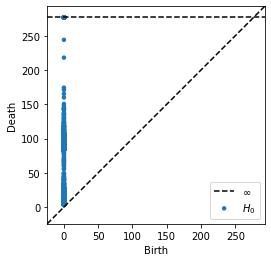

Train Epoch: 1 [0/60000 (0%)]	Loss: -14.893073
Train Epoch: 1 [5000/60000 (8%)]	Loss: -18.445728
Train Epoch: 1 [10000/60000 (17%)]	Loss: -15.016981


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


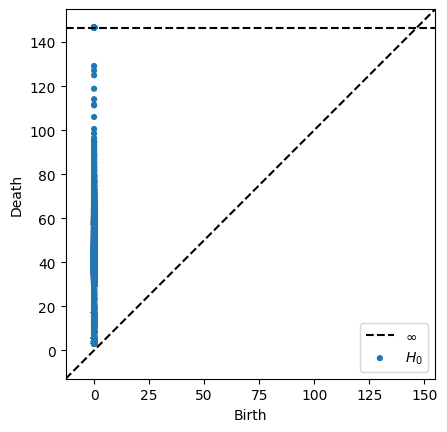

Train Epoch: 1 [15000/60000 (25%)]	Loss: -10.313641
Train Epoch: 1 [20000/60000 (33%)]	Loss: -10.164415


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


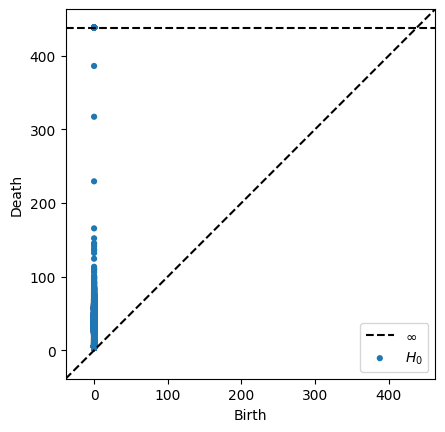

Train Epoch: 1 [25000/60000 (42%)]	Loss: -19.251699
Train Epoch: 1 [30000/60000 (50%)]	Loss: -19.132093
Train Epoch: 1 [35000/60000 (58%)]	Loss: -19.154324


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


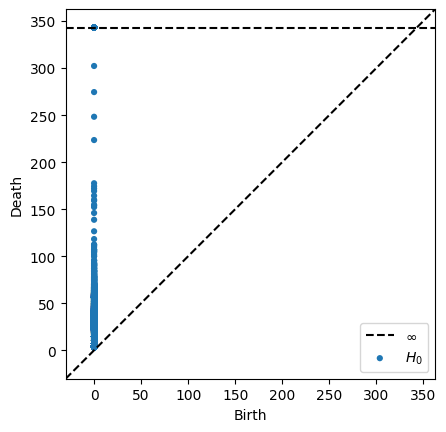

Train Epoch: 1 [40000/60000 (67%)]	Loss: -20.409317
Train Epoch: 1 [45000/60000 (75%)]	Loss: -20.259851


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


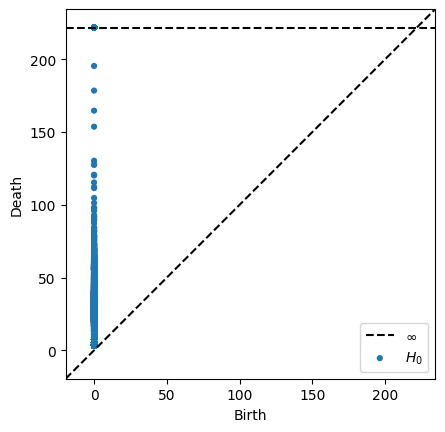

Train Epoch: 1 [50000/60000 (83%)]	Loss: -14.119694
Train Epoch: 1 [55000/60000 (92%)]	Loss: -14.478231

Test set: Average loss: 0.1482, Accuracy: 9554/10000 (96%)

lambda: 0.01, k: 10


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


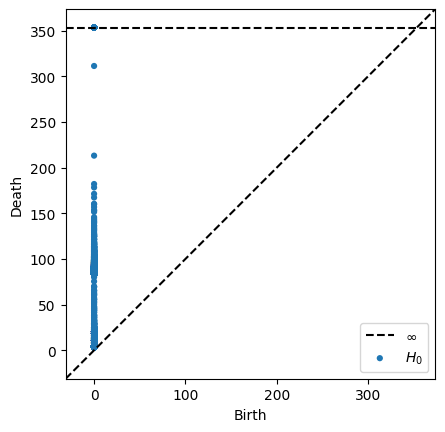

Train Epoch: 1 [0/60000 (0%)]	Loss: -16.227581
Train Epoch: 1 [5000/60000 (8%)]	Loss: -21.531696
Train Epoch: 1 [10000/60000 (17%)]	Loss: -33.756115


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


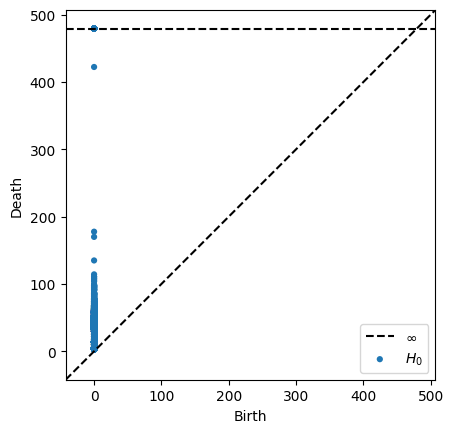

Train Epoch: 1 [15000/60000 (25%)]	Loss: -12.694360
Train Epoch: 1 [20000/60000 (33%)]	Loss: -11.515512


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


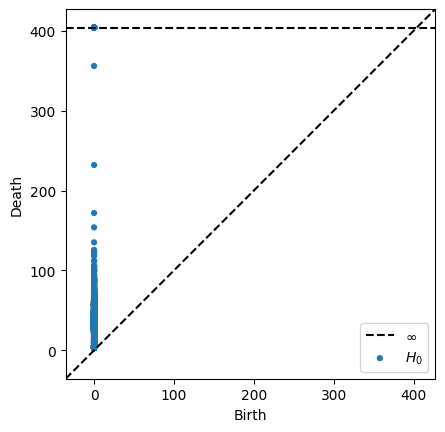

Train Epoch: 1 [25000/60000 (42%)]	Loss: -16.319849
Train Epoch: 1 [30000/60000 (50%)]	Loss: -17.301880
Train Epoch: 1 [35000/60000 (58%)]	Loss: -18.065971


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


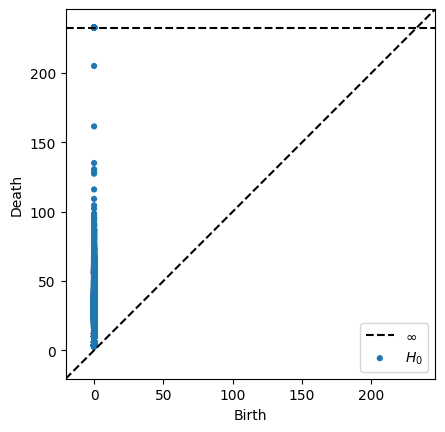

Train Epoch: 1 [40000/60000 (67%)]	Loss: -12.923788
Train Epoch: 1 [45000/60000 (75%)]	Loss: -12.718123


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


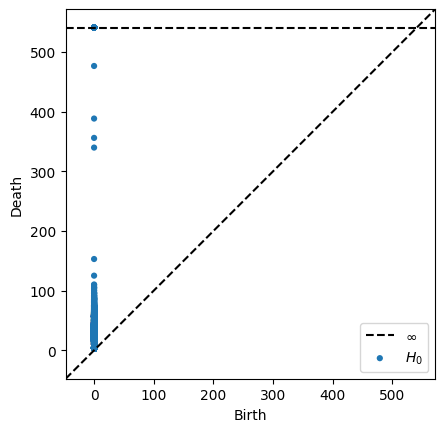

Train Epoch: 1 [50000/60000 (83%)]	Loss: -22.519253
Train Epoch: 1 [55000/60000 (92%)]	Loss: -22.153557

Test set: Average loss: 0.1284, Accuracy: 9631/10000 (96%)

lambda: 0.01, k: 50


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)
<ipython-input-7-6297cfeb6284>:6: RuntimeWarning: divide by zero encountered in true_divide
  NNG = nn_graph.NNGraph(weight_func=lambda x: 1./(np.abs(x)))


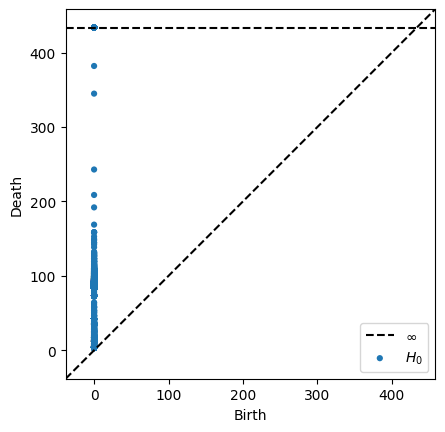

Train Epoch: 1 [0/60000 (0%)]	Loss: -19.428375
Train Epoch: 1 [5000/60000 (8%)]	Loss: -15.524421
Train Epoch: 1 [10000/60000 (17%)]	Loss: -14.021982


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


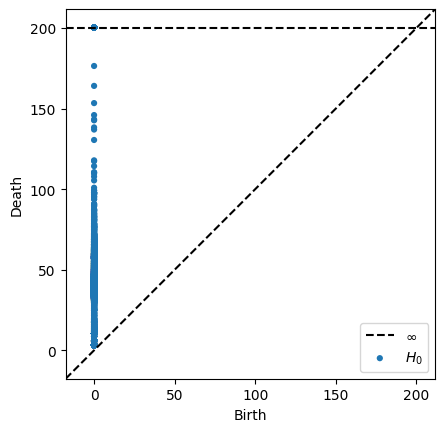

Train Epoch: 1 [15000/60000 (25%)]	Loss: -13.572303
Train Epoch: 1 [20000/60000 (33%)]	Loss: -12.761874


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


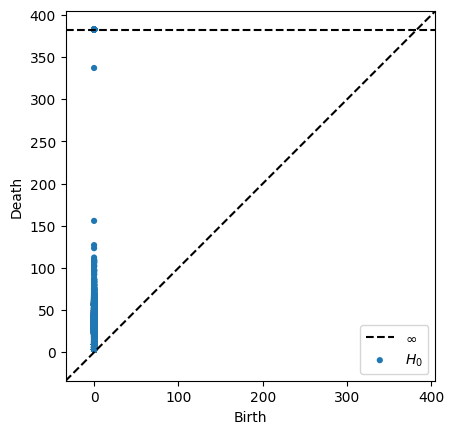

Train Epoch: 1 [25000/60000 (42%)]	Loss: -13.669932
Train Epoch: 1 [30000/60000 (50%)]	Loss: -15.787001
Train Epoch: 1 [35000/60000 (58%)]	Loss: -17.156916


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


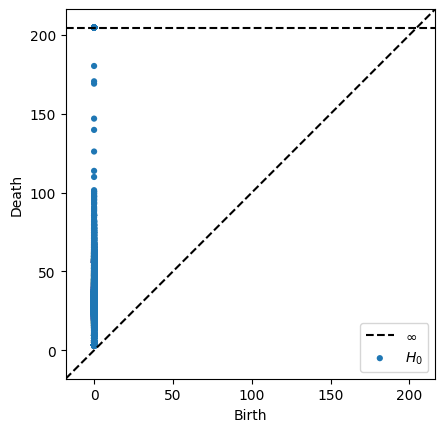

Train Epoch: 1 [40000/60000 (67%)]	Loss: -13.469138
Train Epoch: 1 [45000/60000 (75%)]	Loss: -14.712052


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


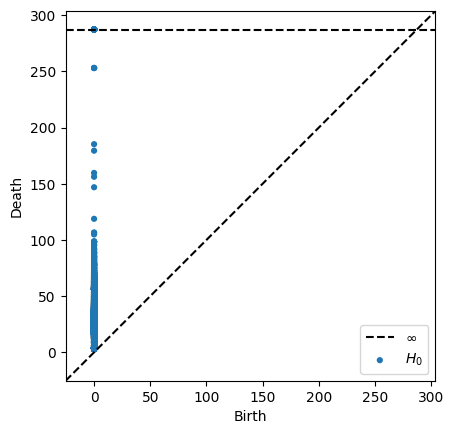

Train Epoch: 1 [50000/60000 (83%)]	Loss: -19.430319
Train Epoch: 1 [55000/60000 (92%)]	Loss: -82.364243

Test set: Average loss: 0.1278, Accuracy: 9628/10000 (96%)

lambda: 0.1, k: 1


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


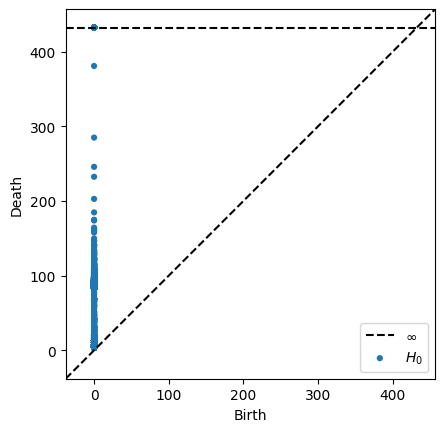

Train Epoch: 1 [0/60000 (0%)]	Loss: -218.442535
Train Epoch: 1 [5000/60000 (8%)]	Loss: -256.741058
Train Epoch: 1 [10000/60000 (17%)]	Loss: -298.763184


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


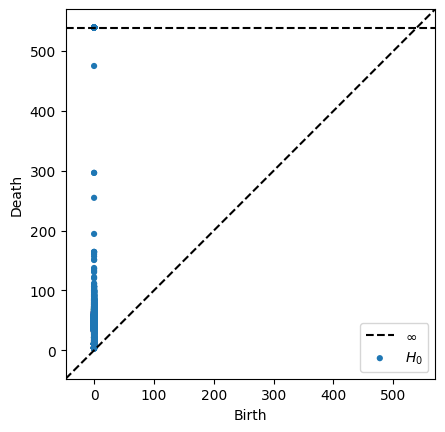

Train Epoch: 1 [15000/60000 (25%)]	Loss: -227.617035
Train Epoch: 1 [20000/60000 (33%)]	Loss: -230.874664


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


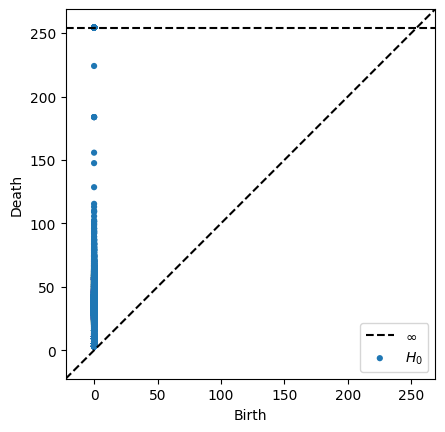

Train Epoch: 1 [25000/60000 (42%)]	Loss: -161.662811
Train Epoch: 1 [30000/60000 (50%)]	Loss: -160.581299
Train Epoch: 1 [35000/60000 (58%)]	Loss: -167.656113


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


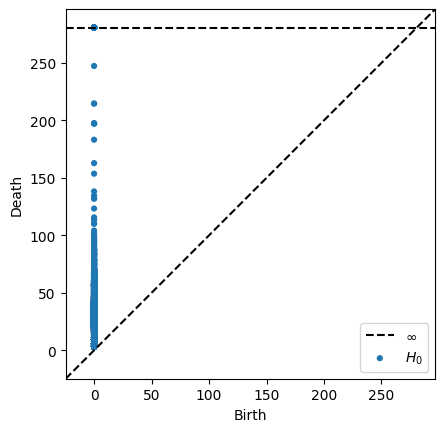

Train Epoch: 1 [40000/60000 (67%)]	Loss: -191.804932
Train Epoch: 1 [45000/60000 (75%)]	Loss: -191.411072


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


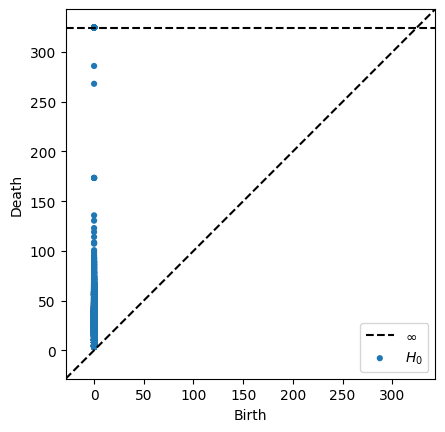

Train Epoch: 1 [50000/60000 (83%)]	Loss: -175.407898
Train Epoch: 1 [55000/60000 (92%)]	Loss: -181.562134

Test set: Average loss: 0.1337, Accuracy: 9618/10000 (96%)

lambda: 0.1, k: 10


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


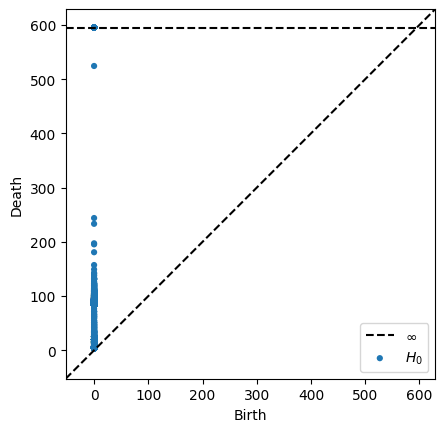

Train Epoch: 1 [0/60000 (0%)]	Loss: -214.300323
Train Epoch: 1 [5000/60000 (8%)]	Loss: -191.824707
Train Epoch: 1 [10000/60000 (17%)]	Loss: -192.314011


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


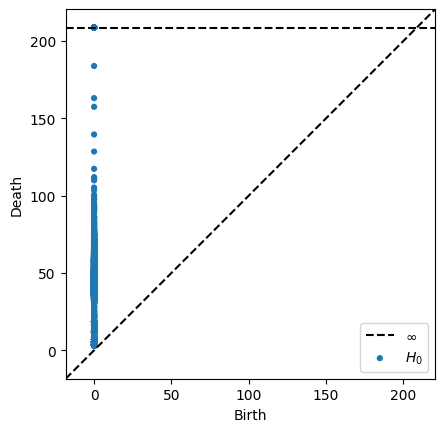

Train Epoch: 1 [15000/60000 (25%)]	Loss: -129.071548
Train Epoch: 1 [20000/60000 (33%)]	Loss: -122.615974


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


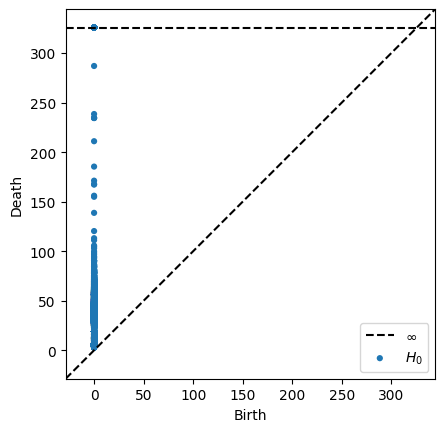

Train Epoch: 1 [25000/60000 (42%)]	Loss: -212.847488
Train Epoch: 1 [30000/60000 (50%)]	Loss: -339.273285
Train Epoch: 1 [35000/60000 (58%)]	Loss: -185.148209


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


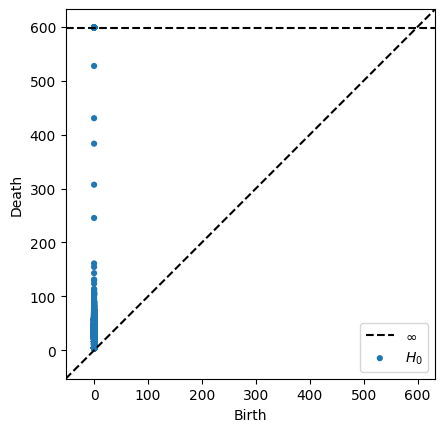

Train Epoch: 1 [40000/60000 (67%)]	Loss: -266.771454
Train Epoch: 1 [45000/60000 (75%)]	Loss: -346.914612


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


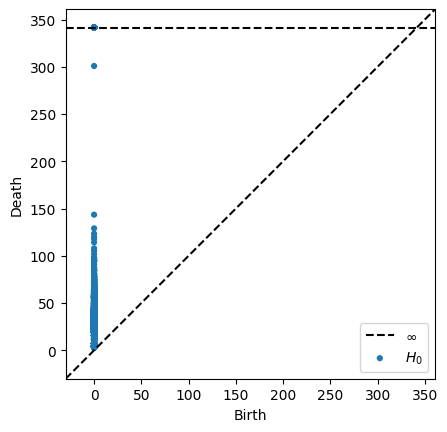

Train Epoch: 1 [50000/60000 (83%)]	Loss: -136.285187
Train Epoch: 1 [55000/60000 (92%)]	Loss: -135.945267

Test set: Average loss: 0.1175, Accuracy: 9659/10000 (97%)

lambda: 0.1, k: 50


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


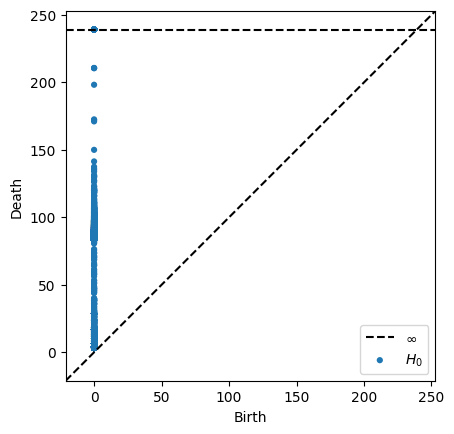

Train Epoch: 1 [0/60000 (0%)]	Loss: -175.154907
Train Epoch: 1 [5000/60000 (8%)]	Loss: -226.903900
Train Epoch: 1 [10000/60000 (17%)]	Loss: -168.883621


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


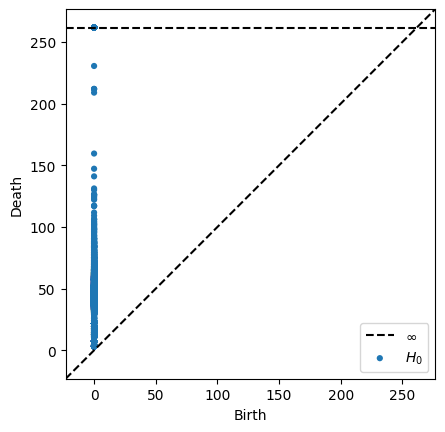

Train Epoch: 1 [15000/60000 (25%)]	Loss: -174.405914
Train Epoch: 1 [20000/60000 (33%)]	Loss: -160.215515


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


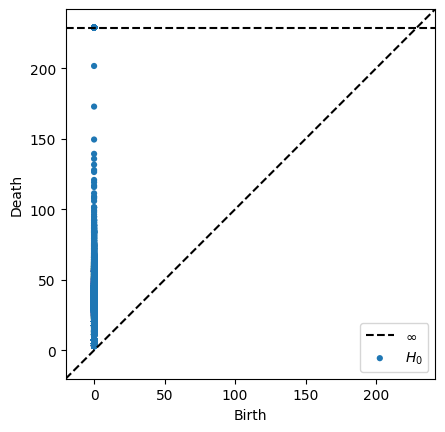

Train Epoch: 1 [25000/60000 (42%)]	Loss: -142.302383
Train Epoch: 1 [30000/60000 (50%)]	Loss: -147.439102
Train Epoch: 1 [35000/60000 (58%)]	Loss: -149.841980


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


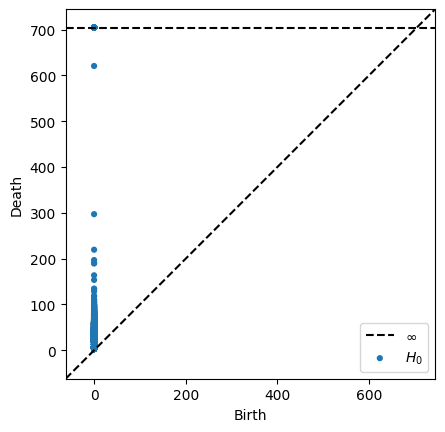

Train Epoch: 1 [40000/60000 (67%)]	Loss: -241.596008
Train Epoch: 1 [45000/60000 (75%)]	Loss: -293.343933


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


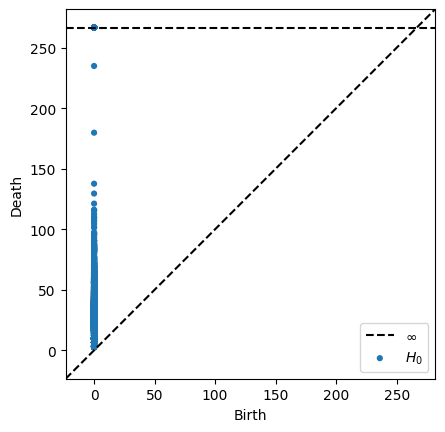

Train Epoch: 1 [50000/60000 (83%)]	Loss: -137.136490
Train Epoch: 1 [55000/60000 (92%)]	Loss: -134.759735

Test set: Average loss: 0.1131, Accuracy: 9675/10000 (97%)

lambda: 1, k: 1


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


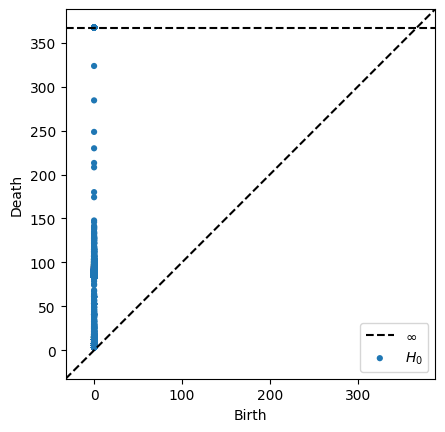

Train Epoch: 1 [0/60000 (0%)]	Loss: -2153.259521
Train Epoch: 1 [5000/60000 (8%)]	Loss: -2128.903809
Train Epoch: 1 [10000/60000 (17%)]	Loss: -2494.661377


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


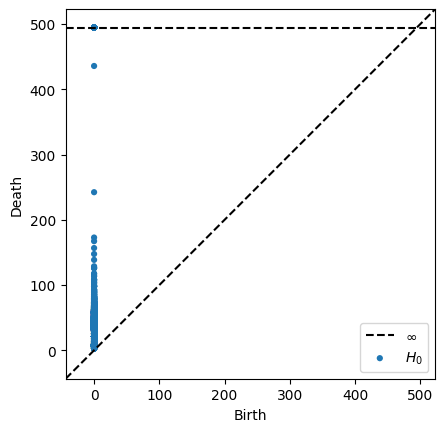

Train Epoch: 1 [15000/60000 (25%)]	Loss: -1820.051880
Train Epoch: 1 [20000/60000 (33%)]	Loss: -2131.225830


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


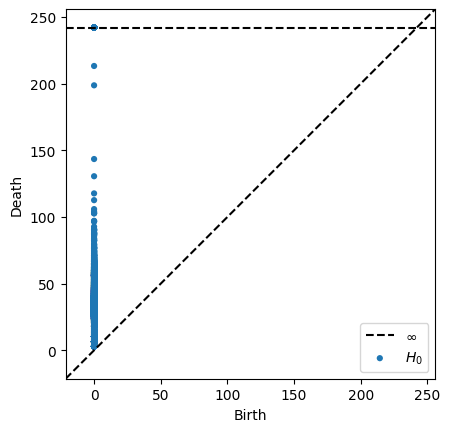

Train Epoch: 1 [25000/60000 (42%)]	Loss: -1332.142334
Train Epoch: 1 [30000/60000 (50%)]	Loss: -1370.648682
Train Epoch: 1 [35000/60000 (58%)]	Loss: -1398.243286


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


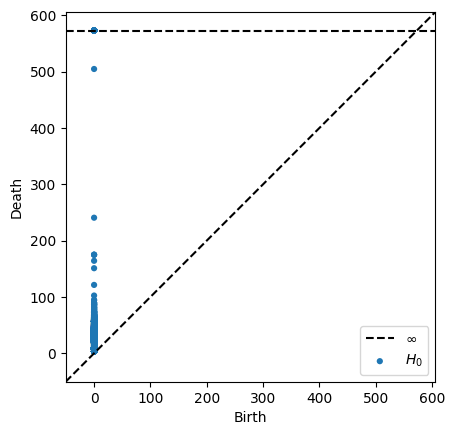

Train Epoch: 1 [40000/60000 (67%)]	Loss: -1713.446045
Train Epoch: 1 [45000/60000 (75%)]	Loss: -1561.125732


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


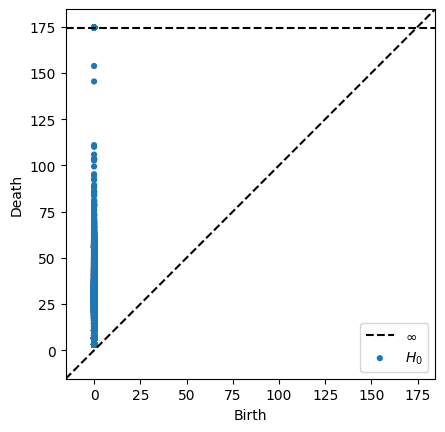

Train Epoch: 1 [50000/60000 (83%)]	Loss: -1141.727539
Train Epoch: 1 [55000/60000 (92%)]	Loss: -1123.197388

Test set: Average loss: 0.1466, Accuracy: 9572/10000 (96%)

lambda: 1, k: 10


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


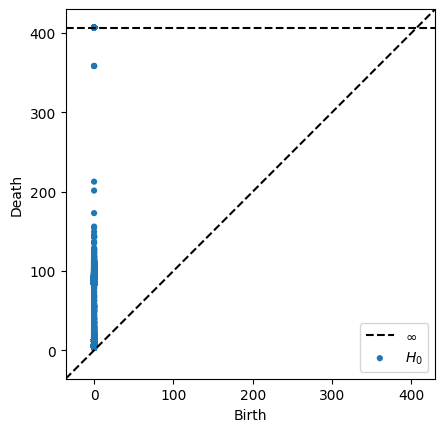

Train Epoch: 1 [0/60000 (0%)]	Loss: -2264.939697
Train Epoch: 1 [5000/60000 (8%)]	Loss: -2544.562988
Train Epoch: 1 [10000/60000 (17%)]	Loss: -1822.244385


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


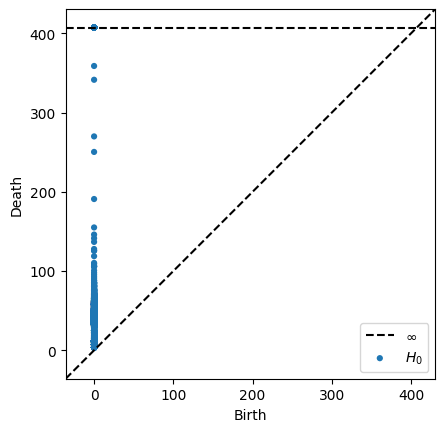

Train Epoch: 1 [15000/60000 (25%)]	Loss: -2284.099854
Train Epoch: 1 [20000/60000 (33%)]	Loss: -2139.287354


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


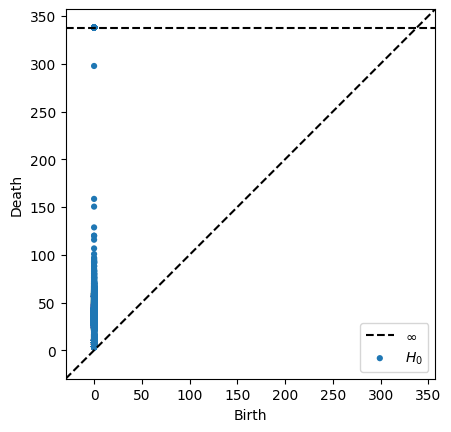

Train Epoch: 1 [25000/60000 (42%)]	Loss: -1394.845825
Train Epoch: 1 [30000/60000 (50%)]	Loss: -1535.331055
Train Epoch: 1 [35000/60000 (58%)]	Loss: -1462.183228


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


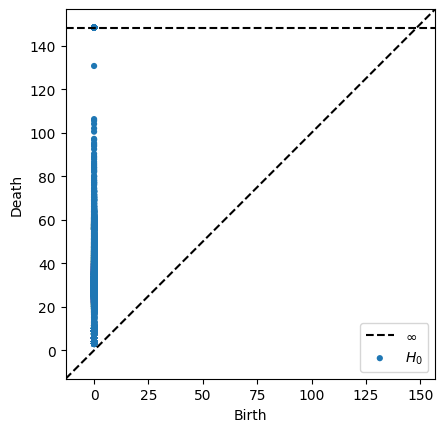

Train Epoch: 1 [40000/60000 (67%)]	Loss: -1035.651855
Train Epoch: 1 [45000/60000 (75%)]	Loss: -985.339722


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


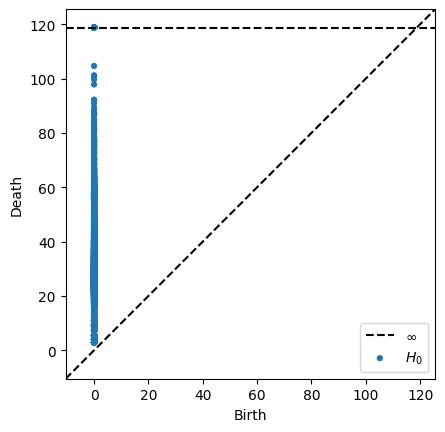

Train Epoch: 1 [50000/60000 (83%)]	Loss: -956.922241
Train Epoch: 1 [55000/60000 (92%)]	Loss: -965.935608

Test set: Average loss: 0.1211, Accuracy: 9642/10000 (96%)

lambda: 1, k: 50


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


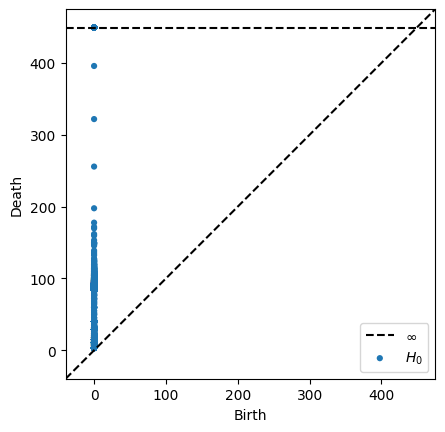

Train Epoch: 1 [0/60000 (0%)]	Loss: -2162.374512
Train Epoch: 1 [5000/60000 (8%)]	Loss: -1875.039185
Train Epoch: 1 [10000/60000 (17%)]	Loss: -2017.481567


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


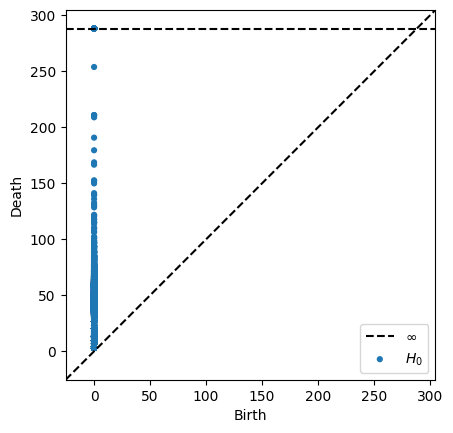

Train Epoch: 1 [15000/60000 (25%)]	Loss: -1887.715210
Train Epoch: 1 [20000/60000 (33%)]	Loss: -1737.229492


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


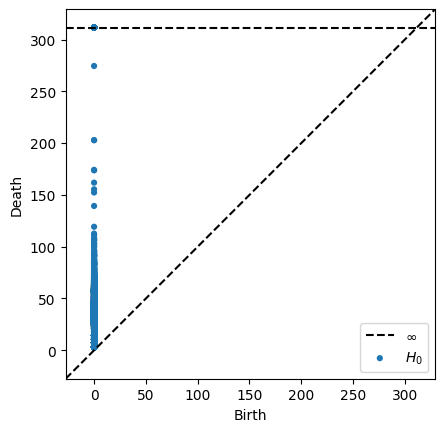

Train Epoch: 1 [25000/60000 (42%)]	Loss: -1755.758545
Train Epoch: 1 [30000/60000 (50%)]	Loss: -1646.112427
Train Epoch: 1 [35000/60000 (58%)]	Loss: -1591.089844


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


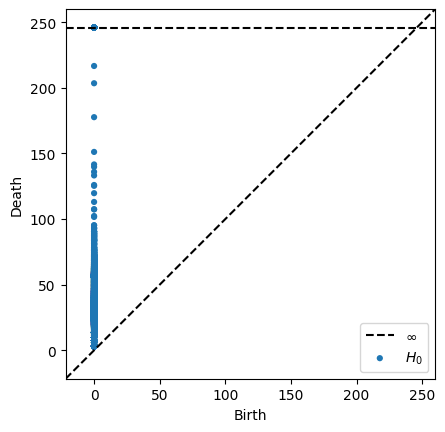

Train Epoch: 1 [40000/60000 (67%)]	Loss: -1564.821899
Train Epoch: 1 [45000/60000 (75%)]	Loss: -1568.899658


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


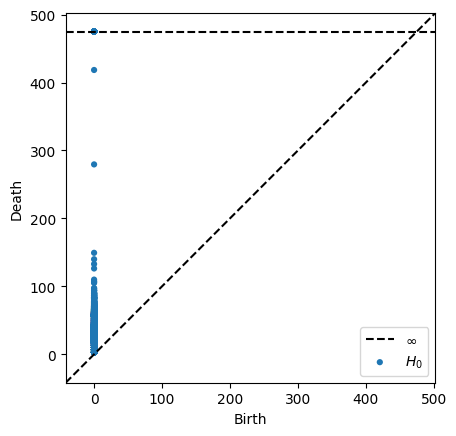

Train Epoch: 1 [50000/60000 (83%)]	Loss: -1674.813477
Train Epoch: 1 [55000/60000 (92%)]	Loss: -1663.073730

Test set: Average loss: 0.1251, Accuracy: 9644/10000 (96%)

lambda: 10, k: 1


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


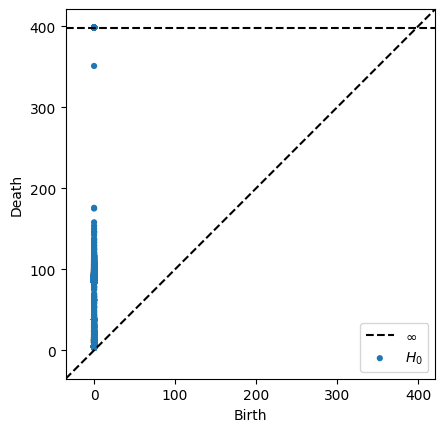

Train Epoch: 1 [0/60000 (0%)]	Loss: -17438.064453
Train Epoch: 1 [5000/60000 (8%)]	Loss: -24100.109375
Train Epoch: 1 [10000/60000 (17%)]	Loss: -19650.039062


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


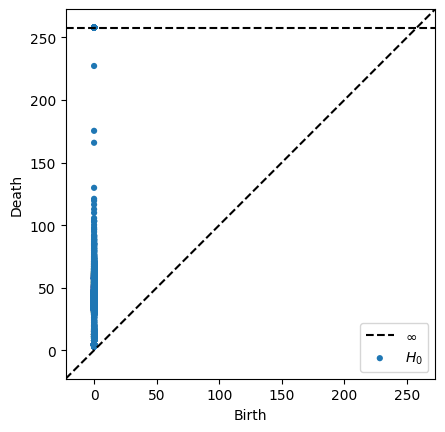

Train Epoch: 1 [15000/60000 (25%)]	Loss: -14751.023438
Train Epoch: 1 [20000/60000 (33%)]	Loss: -15316.901367


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


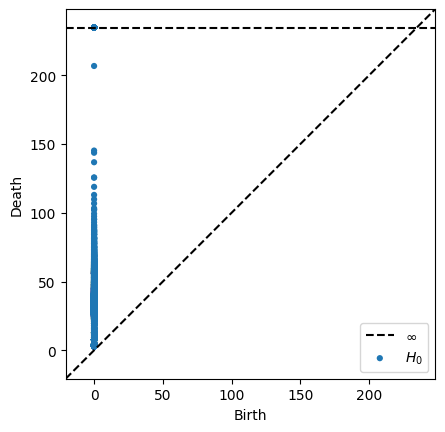

Train Epoch: 1 [25000/60000 (42%)]	Loss: -13324.179688
Train Epoch: 1 [30000/60000 (50%)]	Loss: -13958.339844
Train Epoch: 1 [35000/60000 (58%)]	Loss: -13730.875977


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


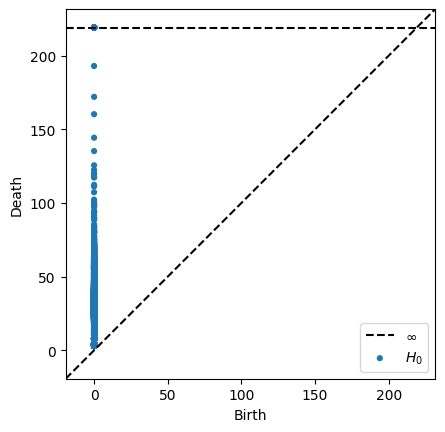

Train Epoch: 1 [40000/60000 (67%)]	Loss: -14281.503906
Train Epoch: 1 [45000/60000 (75%)]	Loss: -14621.296875


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


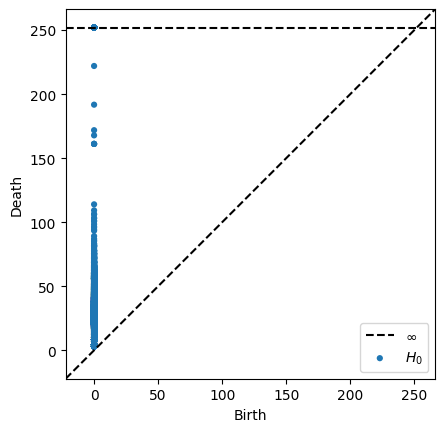

Train Epoch: 1 [50000/60000 (83%)]	Loss: -16212.416992
Train Epoch: 1 [55000/60000 (92%)]	Loss: -80103.015625

Test set: Average loss: 0.1334, Accuracy: 9608/10000 (96%)

lambda: 10, k: 10


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


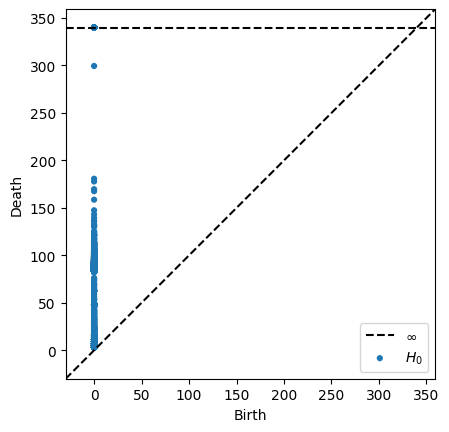

Train Epoch: 1 [0/60000 (0%)]	Loss: -17196.759766
Train Epoch: 1 [5000/60000 (8%)]	Loss: -17339.273438
Train Epoch: 1 [10000/60000 (17%)]	Loss: -15577.336914


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


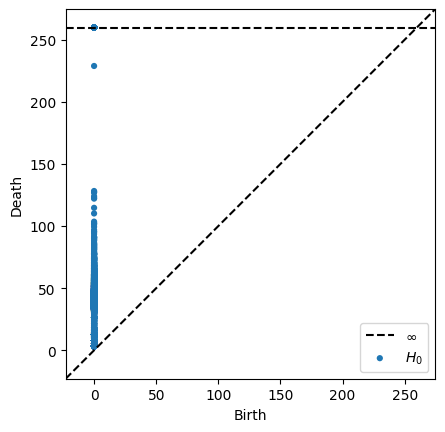

Train Epoch: 1 [15000/60000 (25%)]	Loss: -12500.841797
Train Epoch: 1 [20000/60000 (33%)]	Loss: -12655.065430


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


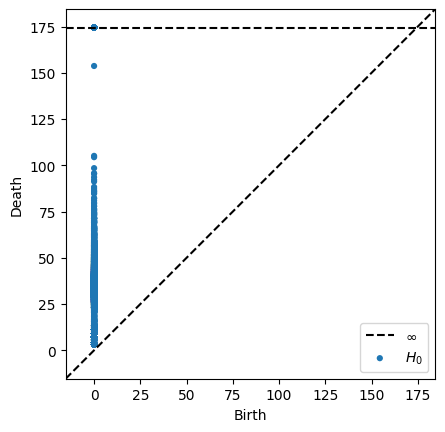

Train Epoch: 1 [25000/60000 (42%)]	Loss: -10178.793945
Train Epoch: 1 [30000/60000 (50%)]	Loss: -10386.394531
Train Epoch: 1 [35000/60000 (58%)]	Loss: -10315.977539


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


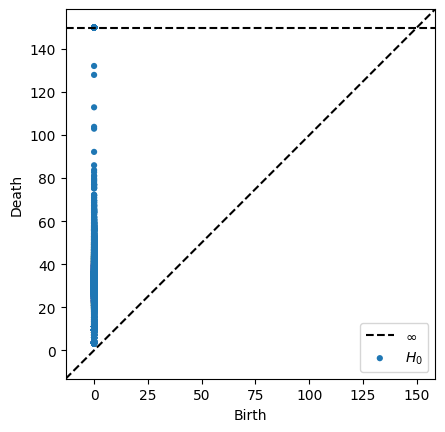

Train Epoch: 1 [40000/60000 (67%)]	Loss: -9898.770508
Train Epoch: 1 [45000/60000 (75%)]	Loss: -10116.734375


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


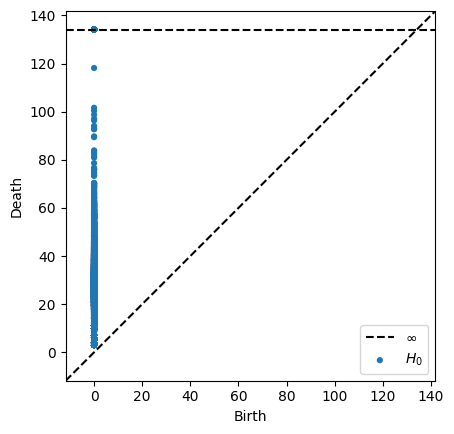

Train Epoch: 1 [50000/60000 (83%)]	Loss: -9818.164062
Train Epoch: 1 [55000/60000 (92%)]	Loss: -10112.284180

Test set: Average loss: 0.1323, Accuracy: 9621/10000 (96%)

lambda: 10, k: 50


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


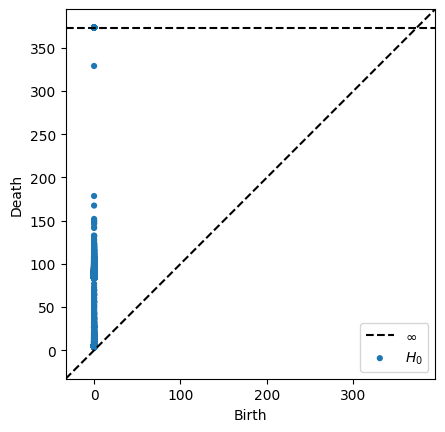

Train Epoch: 1 [0/60000 (0%)]	Loss: -17110.587891
Train Epoch: 1 [5000/60000 (8%)]	Loss: -26220.515625
Train Epoch: 1 [10000/60000 (17%)]	Loss: -18446.466797


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


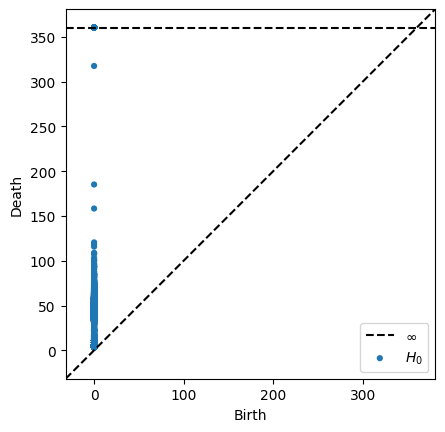

Train Epoch: 1 [15000/60000 (25%)]	Loss: -14520.101562
Train Epoch: 1 [20000/60000 (33%)]	Loss: -14805.207031


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


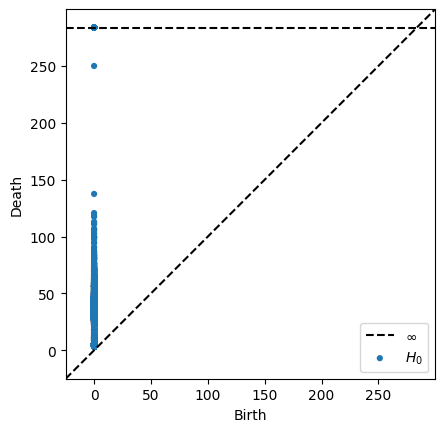

Train Epoch: 1 [25000/60000 (42%)]	Loss: -12925.973633
Train Epoch: 1 [30000/60000 (50%)]	Loss: -11456.716797
Train Epoch: 1 [35000/60000 (58%)]	Loss: -11460.756836


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


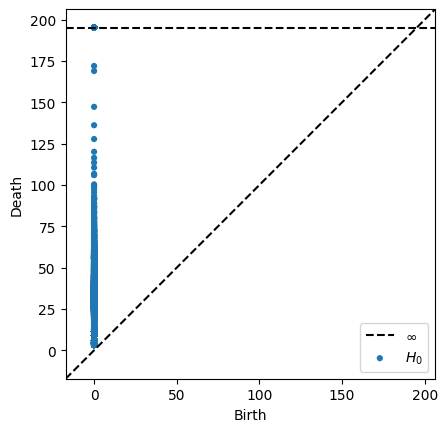

Train Epoch: 1 [40000/60000 (67%)]	Loss: -13359.403320
Train Epoch: 1 [45000/60000 (75%)]	Loss: -13663.033203


<ipython-input-4-ec682435bf86>:32: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.percentile(1./(np.abs(paramsnp)), p)


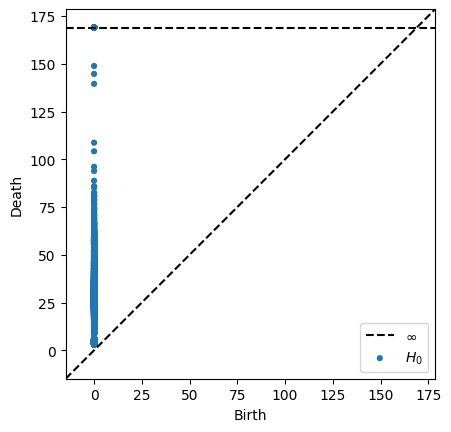

Train Epoch: 1 [50000/60000 (83%)]	Loss: -10959.905273
Train Epoch: 1 [55000/60000 (92%)]	Loss: -10519.580078

Test set: Average loss: 0.1649, Accuracy: 9518/10000 (95%)



In [7]:
for lbda in lbdas:
    for k in ks:
        
        print('lambda: {}, k: {}'.format(lbda, k))

        NNG = nn_graph.NNGraph(weight_func=lambda x: 1./(np.abs(x)))
        model = Net()

        modeldev = Net().to(device)
        optimizer = torch.optim.Adam(modeldev.parameters(), lr=0.001)

        for epoch in range(1, 2):
            train(modeldev, model.param_info, NNG, device, train_loader, optimizer, epoch, lbda, percentile, update_every=25)
            test(modeldev, device, test_loader)
        
        del NNG


lbda = 0.1 Test set: Average loss: 0.1482, Accuracy: 9554/10000 (96%)
lbda = 1   